### YOLOv5 installation
NB! Meant to be run in Google Colab.

### As long as you change the *path_to_project* variable to your path up until the project and *project_root* NATO-Symbols part to the project folder name, code should run seamlessly.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!cd /content
#!rm -rf yolov5
import os

path_to_project="/content/drive/MyDrive/Yolov5"# /home/erkoiv/Desktop
project_root=path_to_project+"/NATO-Symbols"
yolo_dir=project_root+"/yolov5"
#NOTE THAT YOLO EXPECTS THE datasets FOLDER TO BE IN THE SAME ROOT FOLDER AS IT IS
img_dir=project_root+"/datasets/NATO-Symbols/images"
label_dir=project_root+"/datasets/NATO-Symbols/labels"
if yolo_dir==None:
  yolo_dir=input("Please paste the directory you want to install YOLOv5 into. WITHOUT / IN THE END")

%cd {project_root}

![ -d {yolo_dir} ] && echo "YOLO DIRECTORY EXISTS SKIPPING INSTALL"
![ ! -d {yolo_dir} ] && echo "INSTALLING YOLOv5 INTO DESIGNATED DIRECTORY" && git clone https://github.com/ultralytics/yolov5


/content/drive/MyDrive/Yolov5/NATO-Symbols
YOLO DIRECTORY EXISTS SKIPPING INSTALL


### Requirements installation
NB! Meant to be run in Google Colab.

In [9]:
import sys
if project_root+"/scripts" not in sys.path:
  sys.path.append(project_root+"/scripts")
yolo_reqs=yolo_dir+"/requirements.txt"
project_reqs=project_root+"/requirements.txt"
!python3 -m pip install wandb
!python3 -m pip install -r  {yolo_reqs}
!python3 -m pip install -r {project_reqs}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#!cp /content/drive/MyDrive/Yolov5/NATO-Symbols/scripts/augment_tools.py /content #THIS IS ONLY NEEDED IF YOU OTHERWISE GET AN IMPORT ERROR

### Generate a YOLOv5 dataset

This is based on single-symbol images that will be randomly placed on a white canvas to compose a set of multi-symbol images that will be used in training the YOLOv5 weights.

In [29]:
import numpy as np
import cv2
from random import randint
from scipy import ndimage
import os
import re
from tqdm import tqdm
from augment_tools import augment
from matplotlib import pylab as plt
try:
  from google.colab.patches import cv2_imshow
except:
  pass
clean=False
dataset_sz=500
dim=(720,1280)
label_list=["advance_to_contact", "attack", "block", "counterattack", "cover", "delay", "destroy", "disrupt", "guard", "occupy", "retain", "screen", "secure", "seize", "support_by_fire"]
localize_list=["symbol"]

Checking directory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/mihkell


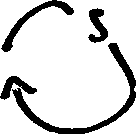

Checking directory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/mihkell2


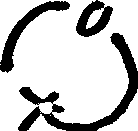

Checking directory  /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw/cadet_drawings


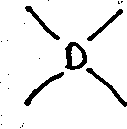

There are 16 labels: ['advance_to_contact' 'attack' 'block' 'counterattack'
 'counterattack_by_fire' 'cover' 'delay' 'destroy' 'disrupt' 'guard'
 'occupy' 'retain' 'screen' 'secure' 'seize' 'support_by_fire']


In [27]:
raws=[]
raw_labels=[]
datasets_root=project_root+"/datasets"
raw_clean_dir=datasets_root+"/raw-clean"
raw_dir=datasets_root+"/raw"

if clean:
  file_list=os.listdir(raw_clean_dir)
  print(file_list)

  for title in file_list:
    raw=cv2.imread(raw_clean_dir+"/"+title, cv2.IMREAD_GRAYSCALE)
    raw=cv2.resize(raw, (150,150), cv2.INTER_AREA)
    raw=cv2.adaptiveThreshold(raw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 19)

    raw=raw[np.argwhere(np.amin(raw,axis=1)<120)[0][0]:np.argwhere(np.amin(raw,axis=1)<120)[-1][0],:]
    raw = raw[:,np.argwhere(np.amin(raw,axis=0) < 120)[0][0]:np.argwhere(np.amin(raw,axis=0) < 120)[-1][0]]

    raws.append(raw)
    raw_labels.append(re.findall('([a-zA-Z_ ]*)\d*.*', title)[0])

  cv2_imshow(raw)

else:
  for subdir in os.listdir(raw_dir):
    dir=raw_dir+"/"+subdir
    file_list=os.listdir(dir)
    print("Checking directory ", dir)

    for title in file_list:
      raw=cv2.imread(dir+"/"+title, cv2.IMREAD_GRAYSCALE)
      raw=cv2.resize(raw, (150,150), cv2.INTER_AREA)
      raw=cv2.adaptiveThreshold(raw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 19)

      raw=raw[np.argwhere(np.amin(raw,axis=1)<120)[0][0]:np.argwhere(np.amin(raw,axis=1)<120)[-1][0],:]
      raw = raw[:,np.argwhere(np.amin(raw,axis=0) < 120)[0][0]:np.argwhere(np.amin(raw,axis=0) < 120)[-1][0]]

      raws.append(raw)
      raw_labels.append(re.findall('([a-zA-Z_ ]*)\d*.*', title)[0])
    cv2_imshow(raw)
print("There are {} labels: {}".format(len(np.unique(raw_labels)), np.unique(raw_labels)))

In [30]:
def generate_image(raw, raw_labels, dim=(850,850),min_sym=5,max_sym=9, max_overlap=15, bg_dim=0.85):
  canvas=np.full(dim,int(bg_dim*255))
  sym_data=[]
  locations=[]

  for i in range(randint(min_sym,max_sym)):
    choice_idx=randint(0,len(raw)-1)
    chosen=np.copy(raw[choice_idx])
    chosen=augment(chosen.astype(np.uint8), apply_resize=True, apply_flip=True, apply_rotation=True, apply_transformation=True, apply_boldness=True)

    while(True):
      overlap=False
      top_leftX=randint(0,dim[0]-chosen.shape[0])
      top_leftY=randint(0,dim[1]-chosen.shape[1])
      for j in range(len(locations)):
        if ((top_leftX < locations[j][1][0]-max_overlap) and (top_leftY < locations[j][1][1]-max_overlap) and (top_leftX+chosen.shape[0] > locations[j][0][0]+max_overlap) and (top_leftY+chosen.shape[1] > locations[j][0][1]+max_overlap)):
          overlap=True
          break
      if not overlap:
        break

    locations.append([[top_leftX,top_leftY],[top_leftX+chosen.shape[0],top_leftY+chosen.shape[1]]])
    canvas[top_leftX:(top_leftX+chosen.shape[0]),top_leftY:(top_leftY+chosen.shape[1])][chosen < 140] = chosen[chosen < 140]
    
    #YOLO xywh format, flip x and y and w and h from previous step
    dimX, dimY = dim
    y=round(((top_leftX+(chosen.shape[0]/2))/dimX),2)
    x=round(((top_leftY+(chosen.shape[1]/2))/dimY),2)
    h=round((chosen.shape[0]/dimX),2)
    w=round((chosen.shape[1]/dimY),2)

    #Class nr
    label=raw_labels[choice_idx]
    if label=="counterattack_by_fire":
      label="counterattack"
    class_nr=label_list.index(label)
    sym_data.append([class_nr, x, y, w, h])


  return canvas, sym_data

In [31]:
if not os.path.exists(img_dir+"/train/img0.jpg"):
  trainnr=int(0.85*dataset_sz)

  for i in tqdm(range(dataset_sz)):
    img, img_data = generate_image(raws, raw_labels, dim)

    if i<trainnr:
      if cv2.imwrite(img_dir+"/train/img"+str(i)+".jpg", img):
        with open(label_dir+"/train/img"+str(i)+".txt", 'w') as f:
          for j in img_data:
            for k in j:
              f.write(str(k)+" ")
            f.write("\n")
    else:
      if cv2.imwrite(img_dir+"/val/img"+str(i)+".jpg", img):
        with open(label_dir+"/val/img"+str(i)+".txt", 'w') as f:
          for j in img_data:
            for k in j:
              f.write(str(k)+" ")
            f.write("\n")


100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


### Training YOLOv5

In [32]:
import wandb
train_dir=yolo_dir+"/train.py"
detect_dir=yolo_dir+"/detect.py"

In [33]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run_id = input("What is the name of the run? Be descriptive. Example 5l-300-colabGPU. ") #5l-300-colabGPU
if not run_id:
  run_id = "unnamed"
!python3 {train_dir} --img 640 --batch 32 --epochs 200 --data NATO-Symbols.yaml --weights yolov5m.pt --project NATO-Symbols-Log --name {run_id} --cache

# Detection

Test the best achieved weights on a set of images.

In [ ]:
weights_dir=project_root+"/NATO-Symbols-Log/"+run_id+"/weights/best.pt"
detect_dir=yolo_dir+"/detect.py"
src_dir=project_root+"/datasets/raw-test"

In [ ]:
#Make all the test images greyscale too to compare results
for title in os.listdir(src_dir):
    img=cv2.imread(src_dir+"/"+title, cv2.IMREAD_GRAYSCALE)
    img=cv2.adaptiveThreshold(img, 200, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 25, 8)
    cv2.imwrite(src_dir+"/gray_"+title, img)

In [ ]:
#!python /content/drive/MyDrive/Yolov5/NATO-Symbols/yolov5/detect.py --weights /content/drive/MyDrive/Yolov5/NATO-Symbols/NATO-Symbols-Log/5l-100/weights/best.pt --source /content/drive/MyDrive/Yolov5/NATO-Symbols/datasets/raw-test --conf-thres 0.8

!python3 {detect_dir} --weights {weights_dir} --source {src_dir} --conf-thres 0.8

# Hyperparameter evolution

Since YOLO has ~25 hyperparameters used for training settings, hyperparameter evolution is a very good way to finetune a model. However, this is a super time and resource expensive process. Here it was attempted to be done for 300 generations of 10 epochs, but due to Colab constraints it was more like 100 generations of 10 epochs.

In [ ]:
run_id = input("What is the name of the run? Be descriptive. Example 5l-300-colabGPU. ") #5l-300-colabGPU
if not run_id:
  run_id = "unnamed"
!python3 {train_dir} --epochs 10 --data NATO-Symbols.yaml --weights yolov5m.pt --project NATO-Symbols-Log --name {run_id} --cache --evolve